# Text Classification using fine-tuned GPT-2 model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1dMTdO5vxdVX0NA2Qe7AV9WGEy8ZH67Xn?usp=sharing) &nbsp;[![Generic badge](https://img.shields.io/badge/GitHub-Source-greensvg)](https://github.com/haocai1992/GPT2-News-Classifier/blob/main/colab-train/gpt2-news-classifier-colab-train.ipynb)

This notebook demonstrates how to use a pre-trained GPT-2 model from [HuggingFace](https://huggingface.co/transformers/) to perform text classification task.

Both BERT and GPT-2 are state-of-the-art transformer models (less "SOTA" now in 2022, with emergence of GPT-3 and other new ones...) that has phenomenal performance in many NLP tasks. One big difference between these two is that GPT-2 was built using decoder blocks, while BERT uses encoder blocks. Therefore, GPT-2 is mostly used in text-generation tasks. Unlike BERT, I couldn't find a lot of articles/tech blogs talking about using GPT-2 for **text classification** tasks. That's why I want to try that out here!

The **main idea** is this: Since GPT2 is a decoder transformer, the last token of the input sequence is used to make predictions about the next token that should follow the input. This means that the last token of the input sequence can be used to for predictions in a classification task too.

## Install and import packages

In [ ]:
# !pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# !pip3 install pandas
# !pip3 install numpy
# !pip3 install sklearn
# !pip3 install tqdm
#pip install transformers

In [ ]:
pip install transformers

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Setup Google Drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/GPT2-News-Classifier/

/content/drive/My Drive/GPT2-News-Classifier


## Read data

The dataset we are going to use in this notebook is the *[BBC News Classification dataset](http://mlg.ucd.ie/datasets/bbc.html)*. You can download the dataset in [Kaggle](https://www.kaggle.com/c/learn-ai-bbc/data).

In [3]:
import pandas as pd

In [59]:
df2 = pd.read_csv('dataset.csv')

In [60]:
df = df2.drop(columns=['Category'])

In [61]:
df.head(1)

,TaskNumber,Summary,Priority,RaisedByID,AssignedToID,AuthorisedByID,StatusCode,ProjectCode,ProjectBreakdownCode,SubCategory,HoursEstimate,HoursActual,HoursActualRound,DeveloperID,DeveloperHoursActual,TaskPerformance,DeveloperPerformance
0,1735,Flag RI on SCM Message Summary screen using me...,1,58,58,6.0,FINISHED,PC2,PBC42,Enhancement,14.0,1.75,2,58,1.75,12.25,12.25


This dataset is in CSV format and it has 2126 different texts, each labeled under one of 5 categories: entertainment, sport, tech, business, or politics. It has two columns, **category** which will be the label; and **text** which will be our input data for GPT-2.

In [62]:
def cluster(df):
  arr=[]
  for i in range(len(df)):
    if df[i] >0 and df[i]<=5:
      group = 'Group5'
    elif df[i] >5 and df[i]<=10:
      group = 'Group10'
    elif df[i] >10 and df[i]<=15:
      group = 'Group15'
    elif df[i] >15 and df[i]<=20:
      group = 'Group20'
    elif df[i] >20 and df[i]<=25:
      group = 'Group25'
    elif df[i] >25 and df[i]<=30:
      group = 'Group30'
    elif df[i] >30 and df[i]<=60:
      group = 'Group60'
    elif df[i] >60 and df[i]<=90:
      group = 'Group90'
    elif df[i] >90 and df[i]<=3000:
      group = 'Group100'

    arr.append(group)

  return(arr)

In [63]:
y=df['HoursActualRound']
df['cluster'] = pd.DataFrame(cluster(df['HoursActualRound']))

In [64]:
df.head(1)

,TaskNumber,Summary,Priority,RaisedByID,AssignedToID,AuthorisedByID,StatusCode,ProjectCode,ProjectBreakdownCode,SubCategory,HoursEstimate,HoursActual,HoursActualRound,DeveloperID,DeveloperHoursActual,TaskPerformance,DeveloperPerformance,cluster
0,1735,Flag RI on SCM Message Summary screen using me...,1,58,58,6.0,FINISHED,PC2,PBC42,Enhancement,14.0,1.75,2,58,1.75,12.25,12.25,Group5


In [65]:
df.rename(columns = {'Summary':'Text', 'cluster':'Category'}, inplace = True)

In [66]:
df.head(1)

,TaskNumber,Text,Priority,RaisedByID,AssignedToID,AuthorisedByID,StatusCode,ProjectCode,ProjectBreakdownCode,SubCategory,HoursEstimate,HoursActual,HoursActualRound,DeveloperID,DeveloperHoursActual,TaskPerformance,DeveloperPerformance,Category
0,1735,Flag RI on SCM Message Summary screen using me...,1,58,58,6.0,FINISHED,PC2,PBC42,Enhancement,14.0,1.75,2,58,1.75,12.25,12.25,Group5


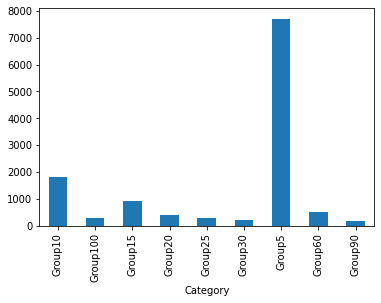

In [67]:
df.groupby("Category").size().plot.bar()

## Preprocessing data (text tokenization)

We need to tokenize the input text in order to feed GPT-2 model with its expected data format. This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. However, unlike BERT which does padding to the right, for GPT-2 we need to do padding to the left, because we need to use the last token for prediction. Therefore we need to adapt GPT2Tokenizer after calling.

In [68]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [69]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [70]:
print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])


In [71]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [72]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|>I will watch Memento tonight


## Dataset class

PyTorch provides a very convenient way to construct cusom Dataset class to facilitate model training. See more details [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Here we will build a custom Dataset class to read in our news data, tokenize them, and store them into containers for batch training.

In [73]:
df['Category'].unique()

array(['Group5', 'Group10', 'Group15', 'Group20', 'Group90', 'Group100',
       'Group30', 'Group25', 'Group60'], dtype=object)

In [76]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    'Group5':0,
    'Group10':1,
    'Group15':2,
    'Group20':3,
    'Group90':7,
    'Group100':8,
    'Group30':5,
    'Group25':4,
    'Group60':6
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=31,
                                truncation=True,
                                return_tensors="pt") for text in df['Text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Split training-test dataset

One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [77]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

9839 1230 1230


## Model building

Now comes to the most important part of this notebook. We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 5 numbers which corresponds to our five news categories!

For more information about how to build customized models in PyTorch, see [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [78]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop

Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Since this is a multi-class classification problem, I picked [cross-entropy-loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function ("criterion"), and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as the optimization algorithm.

In [79]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 40
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=9, max_seq_len=31, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 4920/4920 [06:16<00:00, 13.08it/s]


Epochs: 1 | Train Loss:  0.617             | Train Accuracy:  0.636             | Val Loss:  0.552             | Val Accuracy:  0.661


100%|██████████| 4920/4920 [06:13<00:00, 13.16it/s]


Epochs: 2 | Train Loss:  0.478             | Train Accuracy:  0.693             | Val Loss:  0.500             | Val Accuracy:  0.697


100%|██████████| 4920/4920 [06:14<00:00, 13.15it/s]


Epochs: 3 | Train Loss:  0.325             | Train Accuracy:  0.786             | Val Loss:  0.518             | Val Accuracy:  0.711


100%|██████████| 4920/4920 [06:14<00:00, 13.14it/s]


Epochs: 4 | Train Loss:  0.226             | Train Accuracy:  0.853             | Val Loss:  0.554             | Val Accuracy:  0.715


100%|██████████| 4920/4920 [06:13<00:00, 13.16it/s]


Epochs: 5 | Train Loss:  0.159             | Train Accuracy:  0.898             | Val Loss:  0.605             | Val Accuracy:  0.747


100%|██████████| 4920/4920 [06:13<00:00, 13.16it/s]


Epochs: 6 | Train Loss:  0.126             | Train Accuracy:  0.923             | Val Loss:  0.618             | Val Accuracy:  0.707


100%|██████████| 4920/4920 [06:15<00:00, 13.12it/s]


Epochs: 7 | Train Loss:  0.107             | Train Accuracy:  0.931             | Val Loss:  0.691             | Val Accuracy:  0.741


100%|██████████| 4920/4920 [06:13<00:00, 13.17it/s]


Epochs: 8 | Train Loss:  0.088             | Train Accuracy:  0.943             | Val Loss:  0.699             | Val Accuracy:  0.729


100%|██████████| 4920/4920 [06:13<00:00, 13.17it/s]


Epochs: 9 | Train Loss:  0.112             | Train Accuracy:  0.930             | Val Loss:  0.655             | Val Accuracy:  0.713


100%|██████████| 4920/4920 [06:09<00:00, 13.33it/s]


Epochs: 10 | Train Loss:  0.092             | Train Accuracy:  0.940             | Val Loss:  0.738             | Val Accuracy:  0.721


100%|██████████| 4920/4920 [06:11<00:00, 13.25it/s]


Epochs: 11 | Train Loss:  0.069             | Train Accuracy:  0.958             | Val Loss:  0.763             | Val Accuracy:  0.727


100%|██████████| 4920/4920 [06:15<00:00, 13.10it/s]


Epochs: 12 | Train Loss:  0.074             | Train Accuracy:  0.955             | Val Loss:  0.786             | Val Accuracy:  0.720


100%|██████████| 4920/4920 [06:14<00:00, 13.13it/s]


Epochs: 13 | Train Loss:  0.065             | Train Accuracy:  0.958             | Val Loss:  0.759             | Val Accuracy:  0.720


100%|██████████| 4920/4920 [06:06<00:00, 13.44it/s]


Epochs: 14 | Train Loss:  0.058             | Train Accuracy:  0.963             | Val Loss:  0.831             | Val Accuracy:  0.689


100%|██████████| 4920/4920 [06:04<00:00, 13.48it/s]


Epochs: 15 | Train Loss:  0.056             | Train Accuracy:  0.963             | Val Loss:  0.823             | Val Accuracy:  0.728


100%|██████████| 4920/4920 [06:05<00:00, 13.46it/s]


Epochs: 16 | Train Loss:  0.071             | Train Accuracy:  0.952             | Val Loss:  0.800             | Val Accuracy:  0.733


100%|██████████| 4920/4920 [06:05<00:00, 13.48it/s]


Epochs: 17 | Train Loss:  0.053             | Train Accuracy:  0.966             | Val Loss:  0.834             | Val Accuracy:  0.663


100%|██████████| 4920/4920 [06:05<00:00, 13.47it/s]


Epochs: 18 | Train Loss:  0.074             | Train Accuracy:  0.953             | Val Loss:  0.817             | Val Accuracy:  0.715


100%|██████████| 4920/4920 [06:04<00:00, 13.49it/s]


Epochs: 19 | Train Loss:  0.080             | Train Accuracy:  0.945             | Val Loss:  0.802             | Val Accuracy:  0.702


100%|██████████| 4920/4920 [06:04<00:00, 13.49it/s]


Epochs: 20 | Train Loss:  0.131             | Train Accuracy:  0.911             | Val Loss:  0.720             | Val Accuracy:  0.712


100%|██████████| 4920/4920 [06:05<00:00, 13.48it/s]


Epochs: 21 | Train Loss:  0.132             | Train Accuracy:  0.912             | Val Loss:  0.734             | Val Accuracy:  0.719


100%|██████████| 4920/4920 [06:04<00:00, 13.49it/s]


Epochs: 22 | Train Loss:  0.080             | Train Accuracy:  0.946             | Val Loss:  0.809             | Val Accuracy:  0.710


100%|██████████| 4920/4920 [06:05<00:00, 13.48it/s]


Epochs: 23 | Train Loss:  0.059             | Train Accuracy:  0.961             | Val Loss:  0.792             | Val Accuracy:  0.702


100%|██████████| 4920/4920 [06:05<00:00, 13.46it/s]


Epochs: 24 | Train Loss:  0.092             | Train Accuracy:  0.938             | Val Loss:  0.811             | Val Accuracy:  0.710


100%|██████████| 4920/4920 [06:05<00:00, 13.45it/s]


Epochs: 25 | Train Loss:  0.097             | Train Accuracy:  0.934             | Val Loss:  0.756             | Val Accuracy:  0.728


100%|██████████| 4920/4920 [06:05<00:00, 13.45it/s]


Epochs: 26 | Train Loss:  0.062             | Train Accuracy:  0.957             | Val Loss:  0.827             | Val Accuracy:  0.710


100%|██████████| 4920/4920 [06:06<00:00, 13.44it/s]


Epochs: 27 | Train Loss:  0.065             | Train Accuracy:  0.958             | Val Loss:  0.822             | Val Accuracy:  0.705


100%|██████████| 4920/4920 [06:05<00:00, 13.46it/s]


Epochs: 28 | Train Loss:  0.060             | Train Accuracy:  0.961             | Val Loss:  0.859             | Val Accuracy:  0.715


100%|██████████| 4920/4920 [06:05<00:00, 13.45it/s]


Epochs: 29 | Train Loss:  0.050             | Train Accuracy:  0.966             | Val Loss:  0.865             | Val Accuracy:  0.724


100%|██████████| 4920/4920 [06:04<00:00, 13.48it/s]


Epochs: 30 | Train Loss:  0.090             | Train Accuracy:  0.939             | Val Loss:  0.799             | Val Accuracy:  0.735


100%|██████████| 4920/4920 [06:05<00:00, 13.45it/s]


Epochs: 31 | Train Loss:  0.064             | Train Accuracy:  0.956             | Val Loss:  0.828             | Val Accuracy:  0.719


100%|██████████| 4920/4920 [06:06<00:00, 13.44it/s]


Epochs: 32 | Train Loss:  0.089             | Train Accuracy:  0.938             | Val Loss:  0.769             | Val Accuracy:  0.667


100%|██████████| 4920/4920 [06:05<00:00, 13.45it/s]


Epochs: 33 | Train Loss:  0.061             | Train Accuracy:  0.959             | Val Loss:  0.884             | Val Accuracy:  0.730


100%|██████████| 4920/4920 [06:06<00:00, 13.44it/s]


Epochs: 34 | Train Loss:  0.052             | Train Accuracy:  0.965             | Val Loss:  0.860             | Val Accuracy:  0.699


100%|██████████| 4920/4920 [06:05<00:00, 13.46it/s]


Epochs: 35 | Train Loss:  0.059             | Train Accuracy:  0.958             | Val Loss:  0.873             | Val Accuracy:  0.728


100%|██████████| 4920/4920 [06:06<00:00, 13.44it/s]


Epochs: 36 | Train Loss:  0.083             | Train Accuracy:  0.942             | Val Loss:  0.895             | Val Accuracy:  0.737


100%|██████████| 4920/4920 [06:06<00:00, 13.44it/s]


Epochs: 37 | Train Loss:  0.066             | Train Accuracy:  0.956             | Val Loss:  0.887             | Val Accuracy:  0.719


100%|██████████| 4920/4920 [06:05<00:00, 13.47it/s]


Epochs: 38 | Train Loss:  0.088             | Train Accuracy:  0.937             | Val Loss:  0.707             | Val Accuracy:  0.693


100%|██████████| 4920/4920 [06:06<00:00, 13.44it/s]


Epochs: 39 | Train Loss:  0.098             | Train Accuracy:  0.932             | Val Loss:  0.851             | Val Accuracy:  0.741


100%|██████████| 4920/4920 [06:05<00:00, 13.45it/s]


Epochs: 40 | Train Loss:  0.078             | Train Accuracy:  0.947             | Val Loss:  0.784             | Val Accuracy:  0.698


Looks like the model is already well trained after 1 epoch! This is probably due to the fact that as a pre-trained model with gigantic number of parameters, GPT-2 is already capable of differentiating different text paragraphs without too much tuning.

## Evaluation

After model training, it's recommended to use the test data to evaluate the model performance on unseen data. I build the `evaluate` function according [this PyTorch guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [80]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.682


Another good gauge of model performance is the confusion matrix.

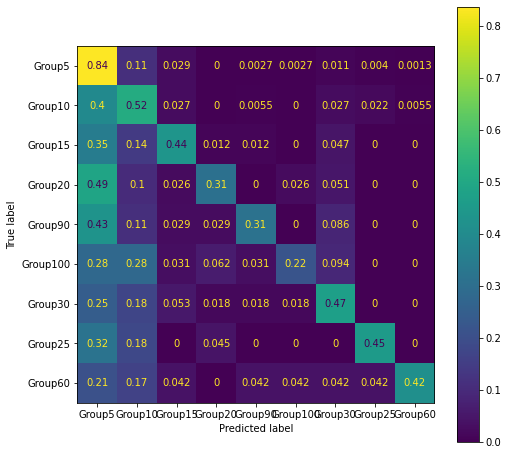

In [81]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## Saving and loading the model

After training, we need to save the model locally. PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [ ]:
# save trained model
# torch.save(model.state_dict(), "./model/gpt2-text-classifier-model.pt")

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In [ ]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("./model/gpt2-text-classifier-model.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)

## Model Inference

Here we want to use the model to generate inferences. Here we use a clipped news from [BBC Politics](https://www.bbc.com/news/uk-60095459) as an example.

In [ ]:
example_text = """
The UK has accused President Putin of plotting to install a pro-Moscow figure to lead Ukraine's government.

The Foreign Office took the unusual step of naming former Ukrainian MP Yevhen Murayev as a potential Kremlin candidate.

Russia has moved 100,000 troops near to its border with Ukraine but denies it is planning an invasion.

UK ministers have warned that the Russian government will face serious consequences if there is an incursion.

In a statement, Foreign Secretary Liz Truss said: "The information being released today shines a light on the extent of Russian activity designed to subvert Ukraine, and is an insight into Kremlin thinking.

"Russia must de-escalate, end its campaigns of aggression and disinformation, and pursue a path of diplomacy."

The Russian Ministry of Foreign Affairs tweeted that the Foreign Office was "circulating disinformation" and urged it to "cease these provocative activities" and "stop spreading nonsense".

"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

the uk has accused president putin of plotting to install a pro-moscow figure to lead ukraine's government. the foreign office took the unusual step of naming former ukrainian mp yevhen murayev as a potential kremlin candidate. russia has moved 100,000 troops near to its border with ukraine but denies it is planning an invasion. uk ministers have warned that the russian government will face serious consequences if there is an incursion. in a statement, foreign secretary liz truss said: "the information being released today shines a light on the extent of russian activity designed to subvert ukraine, and is an insight into kremlin thinking. "russia must de-escalate, end its campaigns of aggression and disinformation, and pursue a path of diplomacy." the russian ministry of foreign affairs tweeted that the foreign office was "circulating disinformation" and urged it to "cease these provocative activities" and "stop spreading nonsense".


After text tokenization, we need to extract two inputs for the model, `input_id` and `mask`. 

In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [ ]:
print(output)

tensor([[-0.4280, -3.0708,  0.4508, -1.4243,  6.4141]],
       grad_fn=<AddmmBackward0>)


The output here is the model output for each label. We can normalize them as probabilities using Softmax algorithm.

In [ ]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [ ]:
print(prob)

tensor([1.0635e-03, 7.5683e-05, 2.5610e-03, 3.9268e-04, 9.9591e-01],
       grad_fn=<SelectBackward0>)


Let's see if our predictor can correctly classify this news as "politics".

In [ ]:
labels_map = {
    0: "business",
    1: "entertainment",
    2: "sport",
    3: "tech",
    4: "politics"
         }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)

politics


It can!

## Clear cache

If you are using PyTorch's CUDA version, remember to clear cache after running this notebook to avoid re-run issues.

In [ ]:
# torch.cuda.empty_cache()